In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [3]:
%load_ext autoreload
%autoreload 2


In [4]:

# Load the CSV file into a dataframe
# dfv00 = pd.read_csv("reps-exp-rep-code-v0.0/gnn_reps_exp_rep_code_results.csv") #initial sweep with small n_train
# dfv01 = pd.read_csv("reps-exp-rep-code-v0.1/gnn_reps_exp_rep_code_results.csv") # more n_train, larger lr sweep

#v0.2: much smaller betas, but too much statistical noise to actually see an effect. Also, half the lr's are too big.
# dfv02 = pd.read_csv("reps-exp-rep-code-v0.2/gnn_reps_exp_rep_code_results.csv") 
# df = df[(df["lr"] >= 0.01) & (df["lr"] <= 0.03)]

# sweep over betas in [1, 1.1, 1.2, 1.3, 1.4], n_train up to 16000ish, first run with n_trials > 1 (MIXED INITIAL STATES in data)
dfv03 = pd.read_csv("results/reps-exp-rep-code-v0.3/gnn_reps_exp_rep_code_results.csv")



In [5]:
# df = pd.concat([dfv00, dfv01])
df = dfv03

# remove all lr greater than 0.03 or less than 0.01


In [6]:
df.head()

,job_id,epoch,train_loss,train_acc,val_loss,val_acc,vs_lookup,vs_minweight,lr,batch_size,gcn_depth,gcn_min,mlp_depth,mlp_max,n_train,beta,job_id.1,total_parameters,total_time,total_epochs
0,0,170,0.246348,0.929688,0,0.883801,0,-998.116199,0.015,256,4,32,3,128,512,1.0,0,55969,180.401257,837
1,1,230,0.310984,0.907959,0,0.891768,0,-998.108232,0.010,128,4,32,4,128,8192,1.0,1,56481,639.982950,769
2,2,30,0.379426,0.891490,0,0.891057,0,-998.108943,0.020,128,4,32,3,128,16192,1.0,2,55969,648.015419,533
3,3,490,0.378199,0.897949,0,0.890440,0,-998.109560,0.030,128,2,32,3,128,4096,1.0,3,23009,363.930811,1038
4,4,360,0.371133,0.896362,0,0.891675,0,-998.108325,0.020,128,2,64,3,128,8192,1.0,4,43713,628.306797,1061


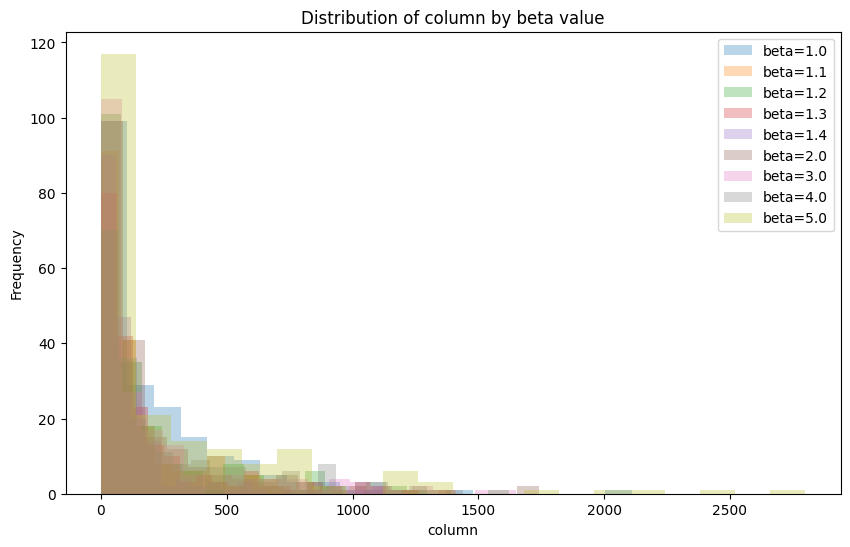

In [7]:
# Create histogram overlaying distributions for different beta values
fig, ax = plt.subplots(figsize=(10, 6))

# Get unique beta values
unique_betas = df["beta"].unique()

# Create histogram for each beta value
for beta in unique_betas:
    subset = df[df["beta"] == beta]
    ax.hist(subset["epoch"], alpha=0.3, label=f"beta={beta}", bins=20)

ax.set_xlabel("column")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of column by beta value")
ax.legend()
plt.show()


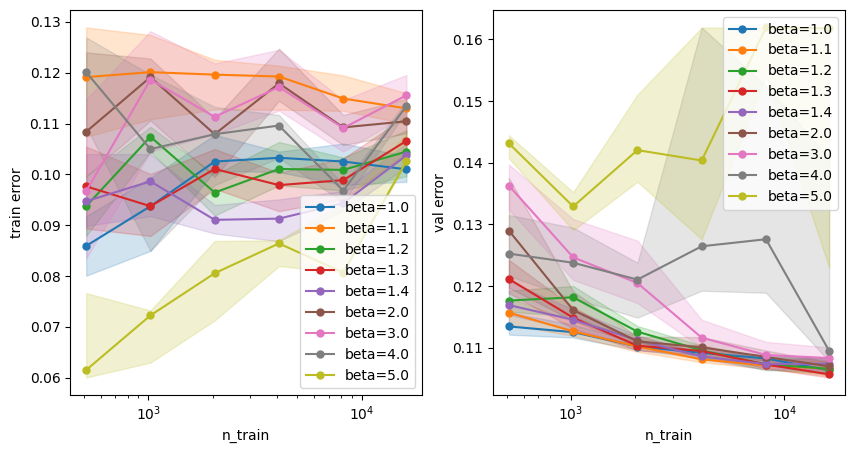

In [12]:
# NEED TO INCREASE LEARNING RATE A LOT

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=False)
betas = np.array(sorted(list(df["beta"].unique())))
# betas = betas[:-3]
# create a list of colors as long as betas
colors = [f"C{i}" for i in range(len(betas))]

labels = ["train error", "val error"]
# n_train = 4096
x_column = 'n_train'
for p, metric in enumerate(["train_acc", "val_acc"]):
    ax = axes[p]
    for i, beta in enumerate(betas):
        c = colors[i]
        lr_med = []
        lr_ub = []
        lr_lb = []
        xvals = sorted(df[x_column].unique())
        label = f"beta={beta}"
        for j, lr in enumerate(xvals):
            slice = ((df[x_column] == lr) & (df["beta"] == beta))
            median = 1 - df[slice][metric].median()
            # get IQ range of the distribution
            lb = 1 - df[slice][metric].quantile(0.25)
            ub = 1 - df[slice][metric].quantile(0.75)
            lr_med.append(median)
            lr_ub.append(ub)
            lr_lb.append(lb)
        ax.plot(xvals, lr_med, c=c, label=label, marker='o', markersize=5,)
        ax.fill_between(xvals, lr_ub, lr_lb, alpha=0.2, color=c)
        ax.set_xscale('log')
        # ax.set_yscale('log')
        # break
    ax.set_xlabel(x_column)
    ax.set_ylabel(f"{labels[p]}")
    ax.legend()

plt.show()


In [13]:
def make_visualization_by_round(X):
    """Make a histogram of the (weights) of (modded) syndromes in the experimental data.
    
    X has shape (n_data, repetitions, n-1). """

    out = np.zeros(X.shape[2] + 1)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            out[int(np.sum(X[i, j]))] += 1
    return out / np.sum(out)

beta=0, trivial_count=23467, trivial_frac=0.3623239871541502
(41301, 5, 4) (41301,)
beta=1, trivial_count=5931, trivial_frac=0.36199951171875
(10453, 5, 4) (10453,)
beta=1.1, trivial_count=5087, trivial_frac=0.31048583984375
(11297, 5, 4) (11297,)
beta=1.2, trivial_count=5427, trivial_frac=0.33123779296875
(10957, 5, 4) (10957,)
beta=1.3, trivial_count=4920, trivial_frac=0.30029296875
(11464, 5, 4) (11464,)
beta=1.4, trivial_count=5001, trivial_frac=0.30523681640625
(11383, 5, 4) (11383,)


[]

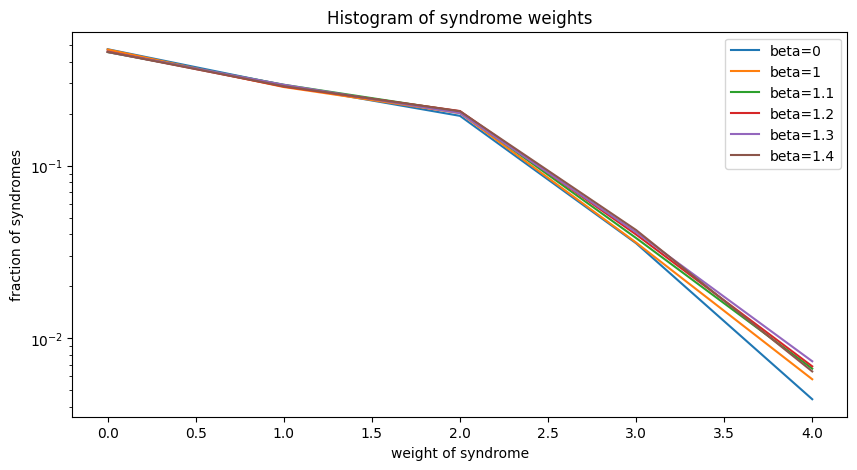

In [14]:
from mldec.datasets.reps_exp_rep_code_data import sample_dataset
from collections import Counter

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for beta in [0, 1, 1.1, 1.2, 1.3, 1.4]:
    dataset_config = {
        "code_size": 5,
        "repetitions": 5,
        "beta": beta,
    }
    if beta == 0:
        n_data = 32384 * 2
    else:
        n_data = 4096*4
    seed = None
    randomize = True
    X, trivial_count, y = sample_dataset(
        n_data, dataset_config, "cpu", seed=None, randomize=True, return_raw=True)
    trivial_frac = trivial_count / n_data
    print(f"beta={beta}, trivial_count={trivial_count}, trivial_frac={trivial_frac}")
    print(X.shape, y.shape)

    hist = make_visualization_by_round(X)
    ax.plot(range(len(hist)), hist, label=f"beta={beta}")
    
ax.legend()
ax.set_xlabel("weight of syndrome")
ax.set_ylabel("fraction of syndromes")
ax.set_title("Histogram of syndrome weights")
ax.semilogy()


In [ ]:
X

In [ ]:
import numpy as np

def plot_hyper_against_val_acc(df, hyper):
    # Get unique values for the hyperparameter
    unique_vals = df[hyper].unique()
    
    # Get unique beta values
    unique_betas = df['beta'].unique()
    
    # Create subplots for each beta
    fig, axes = plt.subplots(1, len(unique_betas), figsize=(5*len(unique_betas), 5))
    if len(unique_betas) == 1:
        axes = [axes]
    
    for beta_idx, beta_val in enumerate(unique_betas):
        ax = axes[beta_idx]
        
        # Filter data for this specific beta
        beta_subset = df[df['beta'] == beta_val]
        
        # Group by hyperparameter value and calculate mean val_acc
        hyper_acc = 1 - beta_subset.groupby(hyper)['val_acc'].mean()
        
        # Create bar plot
        if hyper == "lr":
            xvals = np.log10(hyper_acc.index)
        else:
            xvals = hyper_acc.index
        bars = ax.scatter(xvals, hyper_acc.values)
        
        # Add value labels on bars
        for j, v in enumerate(hyper_acc.values):
            ax.text(hyper_acc.index[j], v + 0.01, f'{v:.3f}', 
                   ha='center', va='bottom', fontsize=8)
        
        ax.set_title(f'Validation error by {hyper} (beta = {beta_val})')
        ax.set_xlabel(hyper)
        ax.set_ylabel('Mean Validation error')

        # ax.set_ylim(0, 1)
        # ax.semilogy()
    # plt.tight_layout()

    plt.show()

plt.close('all')
for hyper in ["lr", "batch_size", "gcn_depth", "gcn_min", "mlp_depth", "mlp_max"]:
    plot_hyper_against_val_acc(df, hyper)